In [1]:
import sqlalchemy as sqla
import getpass as gp

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from datetime import timedelta
import calendar

from prophet import Prophet
from prophet.plot import plot_forecast_component, plot_yearly, plot_weekly, add_changepoints_to_plot

from statsmodels.tsa.stattools import acf

In [2]:
icustays = pd.read_csv('ICUSTAYS.csv')
icustays.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [3]:
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])

In [4]:
icustays['ADMITDATE'] = icustays['INTIME'].dt.date

In [5]:
icustays = icustays.dropna()

In [6]:
years_to_substract = 125
icustays['ADMITDATE'] = icustays['ADMITDATE']-pd.DateOffset(years = years_to_substract)

In [7]:
icustays_df = icustays.groupby(['ADMITDATE'])['LOS'].mean().reset_index()
icustays_df.head()

,ADMITDATE,LOS
0,1975-06-07,0.7911
1,1975-06-09,9.8777
2,1975-06-14,2.8735
3,1975-06-22,2.2924
4,1975-06-26,1.9028


In [8]:
icustays_df.columns = icustays_df.columns.str.replace('ADMITDATE', 'ds')
icustays_df.columns = icustays_df.columns.str.replace('LOS', 'y')

In [9]:
icustays_df.head()

,ds,y
0,1975-06-07,0.7911
1,1975-06-09,9.8777
2,1975-06-14,2.8735
3,1975-06-22,2.2924
4,1975-06-26,1.9028


In [10]:
icustays_df = icustays_df[(icustays_df['ds'] >= '2016-01-01') & (icustays_df['ds'] <= '2023-12-31')].reset_index(drop = True)
icustays_df.head()

,ds,y
0,2016-01-01,1.561225
1,2016-01-02,0.783800
2,2016-01-04,2.679600
3,2016-01-05,9.103700
4,2016-01-06,0.972700


Text(0, 0.5, 'Length of Stay')

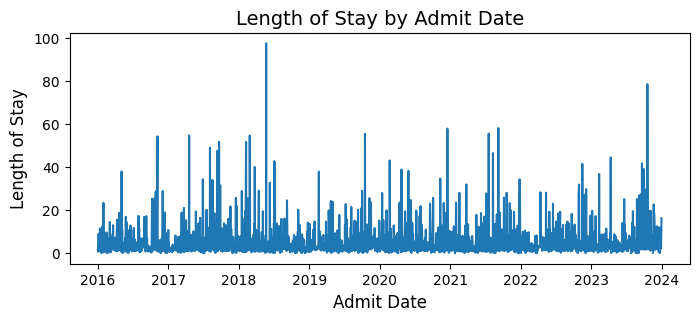

In [11]:
# Plot the data to check the average length of ICU stays over the period of time
fig, ax = plt.subplots(figsize = (8,3))
ax.plot(icustays_df['ds'], icustays_df['y'])

ax.fontsize = 2
ax.set_title('Length of Stay by Admit Date', fontsize = 14)
ax.set_xlabel('Admit Date', fontsize = 12)
ax.set_ylabel('Length of Stay', fontsize = 12)

In [12]:
date_dim = pd.read_csv('date_dimensions.csv')

#convert request_date to datetime format
date_dim['date_val'] = pd.to_datetime(date_dim.date_val)

# convert columns to boolean format (True/False)
date_dim['is_workday'] = date_dim.is_workday == 1
date_dim['is_weekday'] = date_dim.is_weekday == 1
date_dim['is_weekend'] = date_dim.is_weekend == 1
date_dim['is_first_week_of_month'] = date_dim.is_first_week_of_month == 1
date_dim['is_last_week_of_month'] = date_dim.is_last_week_of_month == 1
date_dim['is_december'] = date_dim.is_december == 1
date_dim['is_january'] = date_dim.is_january == 1
date_dim['is_holiday'] = date_dim.is_holiday == 1
date_dim['is_major_holiday'] = date_dim.is_major_holiday == 1
date_dim['is_other_holiday'] = date_dim.is_other_holiday == 1
date_dim['prev_day_is_major_holiday'] = date_dim.prev_day_is_major_holiday == 1
date_dim['next_day_is_major_holiday'] = date_dim.next_day_is_major_holiday == 1
date_dim['prev_day_is_other_holiday'] = date_dim.prev_day_is_other_holiday == 1
date_dim['next_day_is_other_holiday'] = date_dim.next_day_is_other_holiday == 1
date_dim['date_desc'] = date_dim.date_desc.notnull()

date_dim.head()

,date_val,is_workday,is_weekday,is_weekend,weeks_in_month,week_of_month,is_first_week_of_month,is_last_week_of_month,is_december,is_january,is_holiday,is_major_holiday,is_other_holiday,prev_day_is_major_holiday,next_day_is_major_holiday,prev_day_is_other_holiday,next_day_is_other_holiday,date_desc
0,2016-01-01,False,True,False,6,1,True,False,False,True,True,True,False,False,False,True,False,True
1,2016-01-02,False,False,True,6,1,True,False,False,True,False,False,False,True,False,True,False,False
2,2016-01-03,False,False,True,6,2,False,False,False,True,False,False,False,False,False,False,False,False
3,2016-01-04,True,True,False,6,2,False,False,False,True,False,False,False,False,False,False,False,False
4,2016-01-05,True,True,False,6,2,False,False,False,True,False,False,False,False,False,False,False,False


In [13]:
dim_df = pd.merge(icustays_df, date_dim.rename({'date_val': 'ds'}, axis = 1), on = 'ds', how = 'inner')
dim_df.head()

,ds,y,is_workday,is_weekday,is_weekend,weeks_in_month,week_of_month,is_first_week_of_month,is_last_week_of_month,is_december,is_january,is_holiday,is_major_holiday,is_other_holiday,prev_day_is_major_holiday,next_day_is_major_holiday,prev_day_is_other_holiday,next_day_is_other_holiday,date_desc
0,2016-01-01,1.561225,False,True,False,6,1,True,False,False,True,True,True,False,False,False,True,False,True
1,2016-01-02,0.783800,False,False,True,6,1,True,False,False,True,False,False,False,True,False,True,False,False
2,2016-01-04,2.679600,True,True,False,6,2,False,False,False,True,False,False,False,False,False,False,False,False
3,2016-01-05,9.103700,True,True,False,6,2,False,False,False,True,False,False,False,False,False,False,False,False
4,2016-01-06,0.972700,True,True,False,6,2,False,False,False,True,False,False,False,False,False,False,False,False


In [14]:
holiday_dim = date_dim[['date_val', 'is_holiday', 'is_major_holiday', 'is_other_holiday',
                        'prev_day_is_major_holiday', 'next_day_is_major_holiday',
                        'prev_day_is_other_holiday', 'next_day_is_other_holiday', 'date_desc']]

# filter holidays by type into new dataframes
major_holidays = holiday_dim[holiday_dim.is_major_holiday]
other_holidays = holiday_dim[holiday_dim.is_other_holiday]
all_holidays = holiday_dim[holiday_dim.is_holiday]

# define major holidays, set upper_window = 1 to include influence from the day after a major holiday
major_holidays_df = pd.DataFrame({
    'holiday': major_holidays['date_desc'],
    'ds': major_holidays['date_val'],
    'lower_window': 0,
    'upper_window': 1,
})

other_holidays_df = pd.DataFrame({
    'holiday': other_holidays['date_desc'],
    'ds': other_holidays['date_val'],
    'lower_window': 0,
    #'upper_window': 0,
    'upper_window': 1,
})

# create holidays dataframe for Prophet model
holidays = pd.concat((major_holidays_df, other_holidays_df))
holidays.head()

,holiday,ds,lower_window,upper_window
0,True,2016-01-01,0,1
150,True,2016-05-30,0,1
185,True,2016-07-04,0,1
248,True,2016-09-05,0,1
328,True,2016-11-24,0,1


In [15]:
holidays['holiday'] = holidays['holiday'].astype(str)

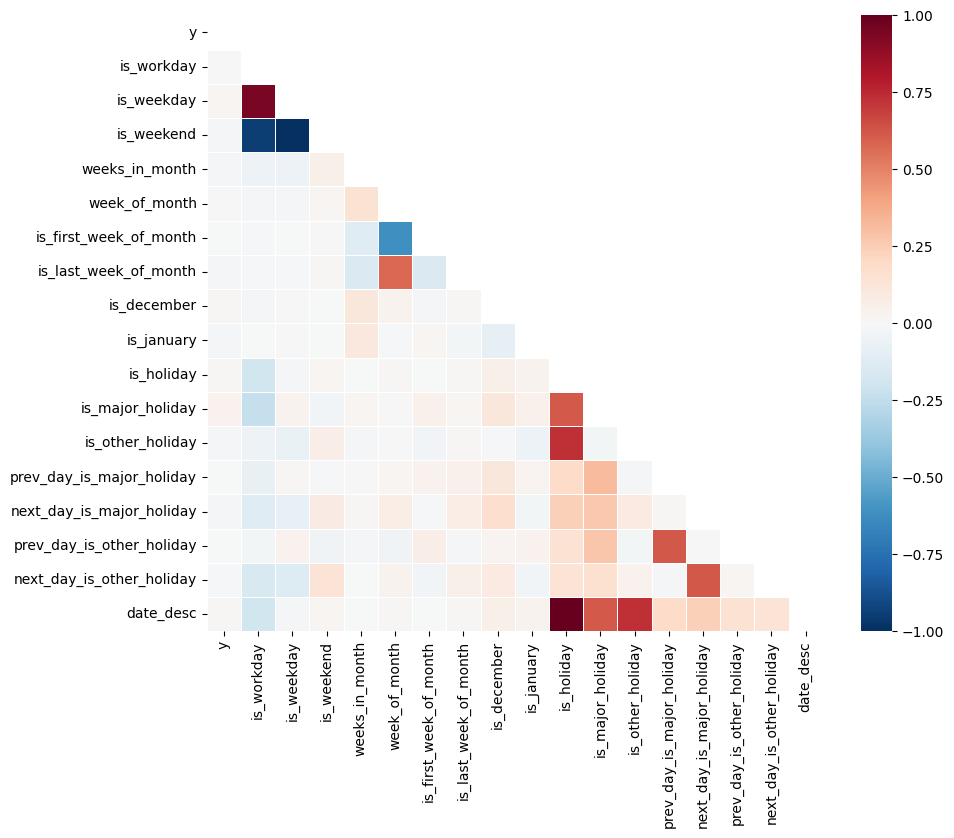

In [16]:
corr_all = dim_df.drop('ds', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all,
            mask = mask,
            square = True,
            linewidths = .5,
            ax = ax,
            cmap = "RdBu_r")
plt.show()

Seasonality Mode: multiplicative


<Axes: >

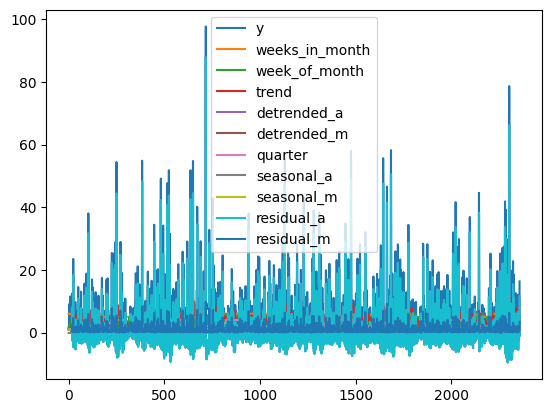

In [17]:
# Create function to calculate the seasonality type
def add_or_mult(df):
    ts = dim_df.set_index('ds')
    #ts['trend'] = ts.rolling(21).mean()
    ts['trend'] = ts['y'].rolling(18).mean()
    ts['detrended_a'] = ts.y - ts.trend
    ts['detrended_m'] = ts.y / ts.trend
    ts['quarter'] = ts.index.quarter

    seasonals = ts.groupby(ts.index.quarter).agg(
        seasonal_a = ('detrended_a', 'mean'),
        seasonal_m = ('detrended_m', 'mean')
        ).reset_index().rename({'ds':'quarter'}, axis = 1)

    ts = ts.merge(seasonals)
    ts['residual_a'] = ts.detrended_a - ts.seasonal_a
    ts['residual_m'] = ts.detrended_m / ts.seasonal_m

    def ssacf(x): return(sum(acf(x, missing= 'drop')**2))
    def compare_ssacf(add, mult):
        if ssacf(add) < ssacf(mult): return('additive')
        else: return("multiplicative")

    return(compare_ssacf(ts.residual_a, ts.residual_m), ts)

# calculate
result, ts = add_or_mult(dim_df)
print('Seasonality Mode:', result)
ts.plot()

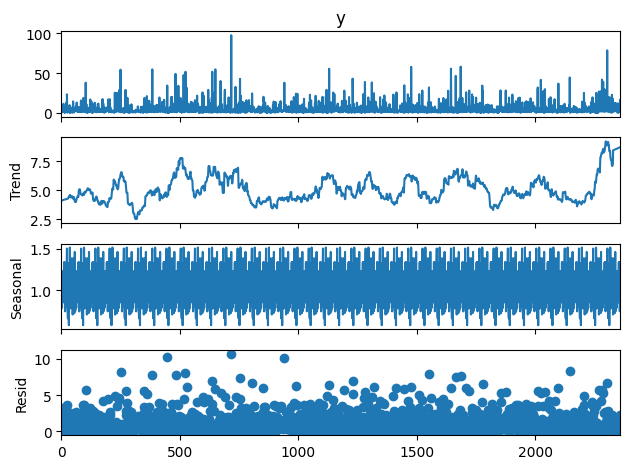

In [18]:
# Decomposing the input data
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(dim_df.y, model='multiplicative', extrapolate_trend='freq', period=60)
decompose.plot().show()

In [19]:
# Set up Projection Dataframe
projection_start_date = '2024-01-01'
projection_end_date = '2027-12-31'

In [20]:
use_workday_and_weekend = True
use_december = False
use_january = False

use_yearly_seasonality = True

In [21]:
# build model, pass in holidays dataframe, set model parameters
m = Prophet(
    interval_width = 0.95, #confidence interval
    holidays = holidays,
    yearly_seasonality = use_yearly_seasonality,
    weekly_seasonality = not(use_workday_and_weekend),
    daily_seasonality = True,
    seasonality_mode = "multiplicative"
    )

if use_workday_and_weekend:
    m.add_seasonality(name = 'is_workday', period = 7, fourier_order = 3, condition_name = 'is_workday')
    m.add_seasonality(name = 'is_weekend', period = 7, fourier_order = 3, condition_name = 'is_weekend')

if use_december: m.add_regressor(name = 'is_december')
if use_january: m.add_regressor(name = 'is_january')


# fit model
m.fit(dim_df)

# create future dataframe with periods to forecast
future = m.make_future_dataframe(periods = (pd.to_datetime(projection_end_date) - dim_df.ds.max()).days)

# join in date dimensions
future_df = pd.merge(future, date_dim.rename({'date_val': 'ds'}, axis = 1), on = 'ds', how = 'left')

DEBUG:cmdstanpy:input tempfile: /tmp/tmp80z8lnk1/tq_nfax9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80z8lnk1/m882fkh0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90400', 'data', 'file=/tmp/tmp80z8lnk1/tq_nfax9.json', 'init=/tmp/tmp80z8lnk1/m882fkh0.json', 'output', 'file=/tmp/tmp80z8lnk1/prophet_modellddg5k1t/prophet_model-20241104031614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:16:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:16:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [22]:
future_df=future_df.dropna()

In [23]:
forecast = m.predict(future_df)

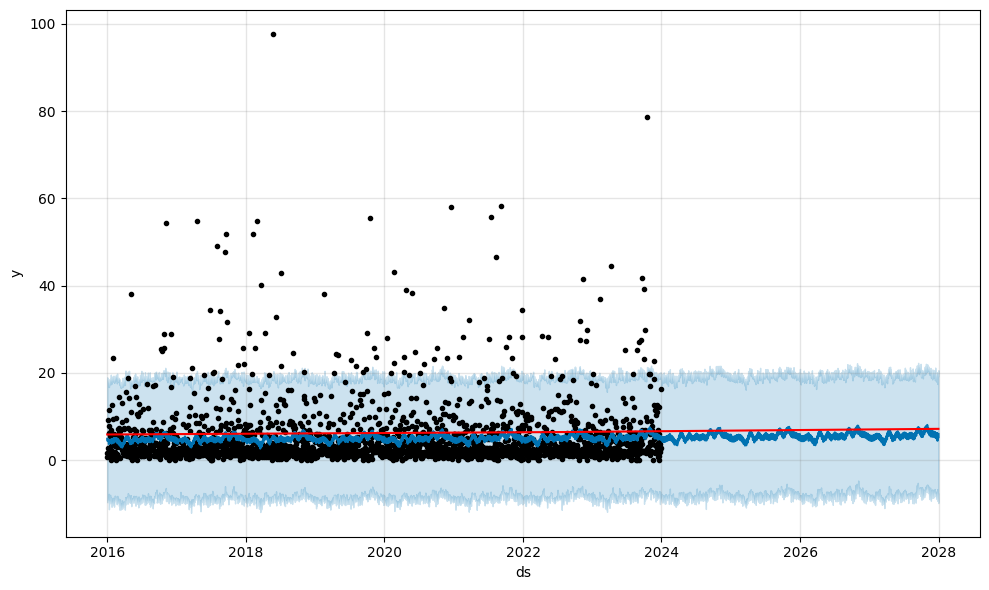

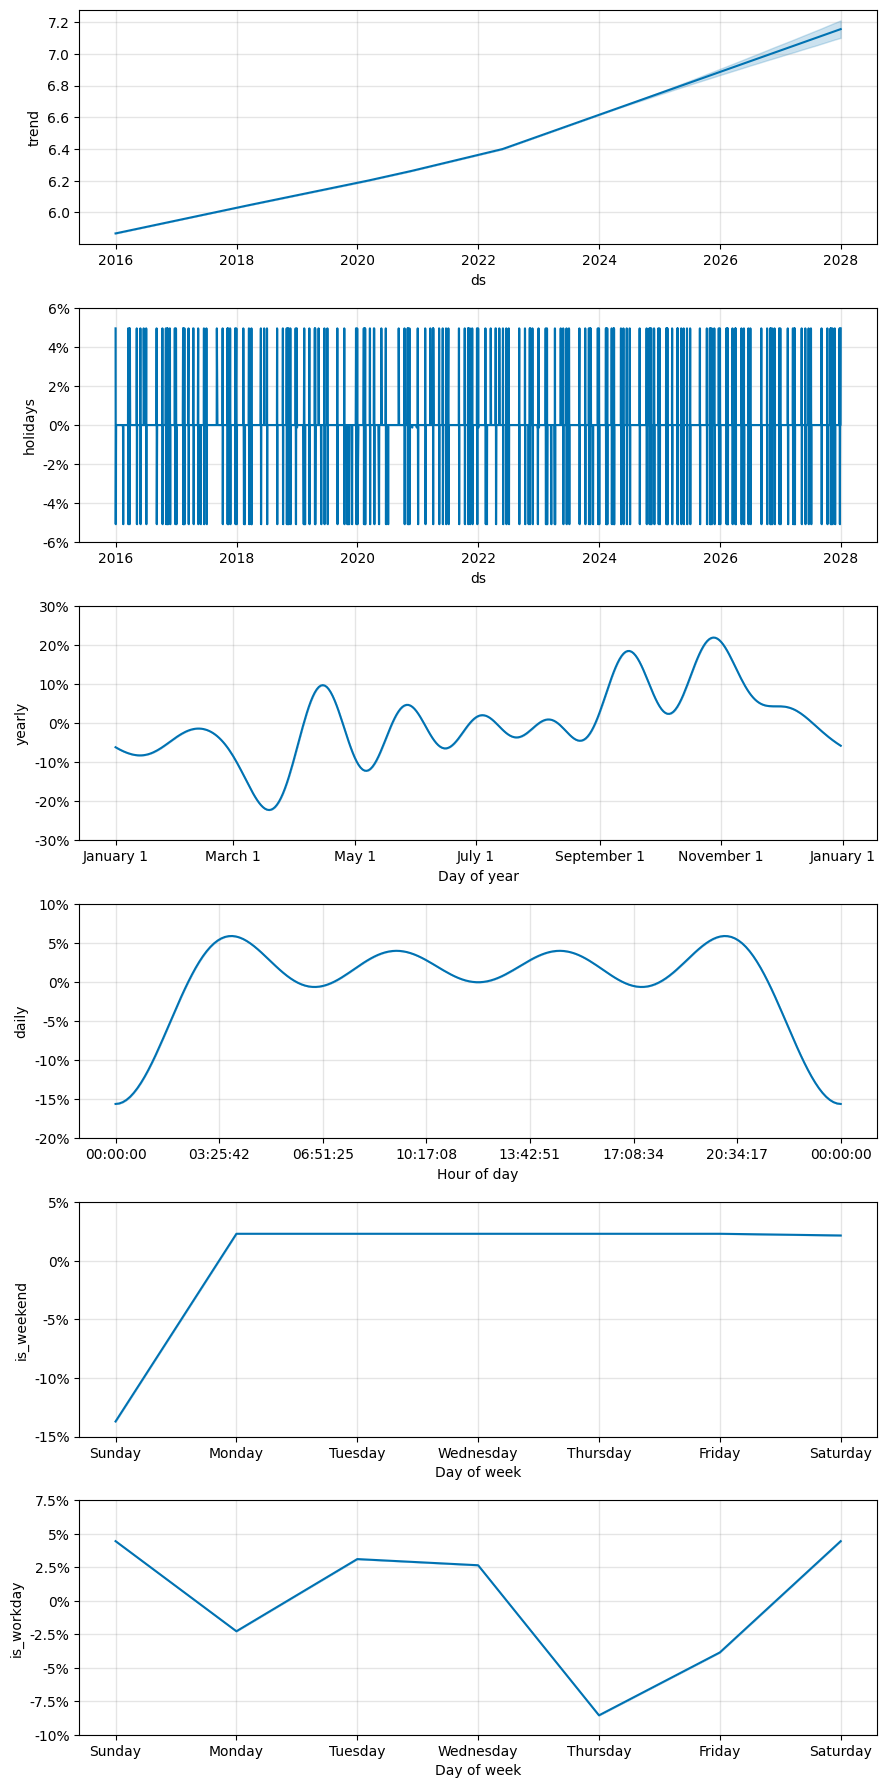

In [24]:
fig1 = m.plot(forecast, uncertainty = True)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast, uncertainty = True)

In [25]:
forecast['month'] = pd.to_datetime(forecast.ds).dt.strftime("%Y-%m-01")
month_agg = forecast.groupby(['month']).agg({'yhat': sum})
print('Number of Months: ', len(month_agg))
month_agg

Number of Months:  144


,yhat
month,
2016-01-01,115.281937
2016-02-01,105.859951
2016-03-01,97.448877
2016-04-01,128.978572
2016-05-01,128.153798
...,...
2027-08-01,175.916401
2027-09-01,200.689154
2027-10-01,205.397935


<Axes: xlabel='month'>

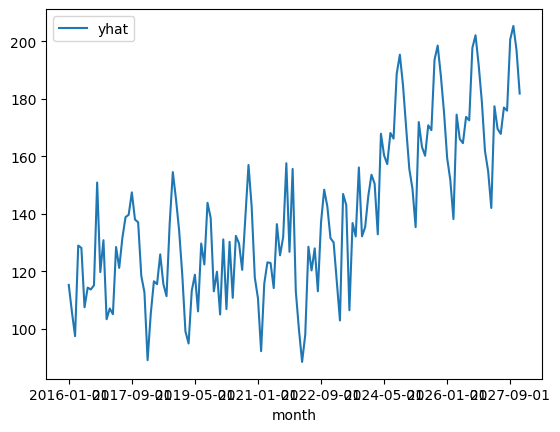

In [26]:
month_agg.plot()

In [27]:
# Export the dataframe to excel file
month_agg.to_excel('ICUSTAYS_Forecast_Output.xlsx', index=True)